# TensorFlow-Powered Robot Vision


Press "shift" + "Enter" to contnue.

Take a picutre in your robot.

In [1]:
import os
# sudo fswebcam -r 1280x720 --no-banner /home/pi/Documents/images/cnn/test_image.png
os.system('fswebcam -r 1280x720 --no-banner /home/pi/Documents/TensorFlow-Powered_Robot_Vision/test_image.png')
# Conversion of the image
os.system('convert /home/pi/Documents/TensorFlow-Powered_Robot_Vision/test_image.png -resize 299x299! /home/pi/Documents/TensorFlow-Powered_Robot_Vision/test_image.png')

0

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
# A couple utility functions to plot grayscale and RGB images:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

# Inception v3

In [3]:
import tensorflow as tf
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [4]:
fetch_pretrained_inception_v3()

In [5]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets","inception","imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [6]:
class_names = load_class_names()

In [7]:
width = 299
height = 299
channels = 3

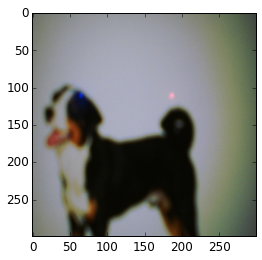

In [8]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("on")
plt.show()

In [9]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [10]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

In [11]:
class_names[np.argmax(predictions_val[0])]

'EntleBucher'

In [12]:
np.argmax(predictions_val, axis=1)

array([241], dtype=int32)

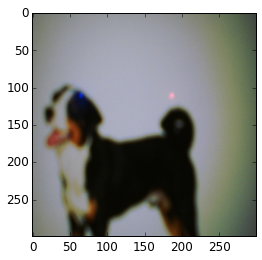

Bernese mountain dog: 0.10%
Appenzeller: 0.16%
boxer: 0.25%
pug, pug-dog: 1.71%
EntleBucher: 96.25%


In [13]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("on")
plt.show()

top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = top_5[np.argsort(predictions_val[0][top_5])]
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100*predictions_val[0][i]))

In [ ]:
# END